# VGGnet Demo (10 Class Example)
# By: Amir Nejad
## Read more: https://amirnejad.medium.com/

In [1]:
import datetime
import random
import argparse
import os,glob,sys
import shutil 
import zipfile,tarfile
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as  sns
from sklearn.metrics import confusion_matrix

#-- tensorflow
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical,multi_gpu_model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from tensorflow.keras import Model
from tensorflow.python.client import  device_lib
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
PATH_AlexNet='../AlexNet/'
sys.path.append(PATH_AlexNet)

#--
from utils import *

In [2]:
tf.__version__

'2.2.0'

In [3]:
#---  Plotting Settings:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (8, 6)

In [4]:
args = argparse.ArgumentParser(description='Training Params')
args.add_argument('--SEED',default=42, type=int, help='seed for random numers')
args.add_argument('--DPI',default=300, type=int, help='DPI for saving figures')
args.add_argument('--save_fig',default=True, type=bool, help='If true saves the figure to the local disk')
args.add_argument('--save_path',default='./results/', type=str, help='Path to save resulsts')
args.add_argument('--model_path',default='./models/', type=str, help='Path to save models')
args.add_argument('--model_name',default='VGGnet', type=str, help='Name of the model')
args.add_argument('--path_images',default='../ILSVRC/Data/CLS-LOC/', type=str, help='*location of Imagenet folders')
args.add_argument('--path_labels',default='../', type=str, help='location of Imagenet labels')
args.add_argument('--image_height',default=224, type=int, help='Image height of Imagenet pictures')
args.add_argument('--image_width',default=224, type=int, help='Image width of Imagenet pictures')
args.add_argument('--EPOCHS',default=40, type=int, help='Number of training Epochs')
args.add_argument('--BATCH_SIZE',default=256, type=int, help='Training batch size')
args.add_argument('--PATIENCE_FRACTION',default=1, type=float, help='Paitence fraction for early stopping. 1 means no early stopping')
args.add_argument('--Subset',default=True, type=bool, help='If true, subest of ImageNet images will be trained here. If false all Imagenet images will be uses.')
selected_classes=['n02909870', 'n13037406', 'n04523525', 'n04204238', 'n02410509', 'n02033041', 'n02493509', 'n03249569', 'n07716358', 'n02483708']
args.add_argument('--Subset_Classes',default=selected_classes, type=list, help='if Subset== True, list of selected categories need to be provided here')

args.add_argument('--train_directory',default='../', type=str, help='**Leave Empty**')
args.add_argument('--validation_directory',default='../', type=str, help='**Leave Empty**')
args = args.parse_args("")

In [5]:
args.train_directory=os.path.join(args.path_images,'train')
args.validation_directory=os.path.join(args.path_images,'val')

In [6]:
nGPUs=len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", nGPUs)

Num GPUs Available:  8


In [7]:
#  dataframe contains categories of data  
cats=pd.read_csv(os.path.join(PATH_AlexNet,'categories.csv'))
# validation  images  labels
val_labels=pd.read_csv(os.path.join(args.path_labels,'LOC_val_solution.csv'))
val_labels['labels']=val_labels['PredictionString'].str.split(' ').str[0]
val_labels['ImageId']=val_labels['ImageId']+'.JPEG'
#random.sample(list(cats.folder_name),10)

In [8]:
val_labels.head(10)

,ImageId,PredictionString,labels
0,ILSVRC2012_val_00048981.JPEG,n03995372 85 1 499 272,n03995372
1,ILSVRC2012_val_00037956.JPEG,n03481172 131 0 499 254,n03481172
2,ILSVRC2012_val_00026161.JPEG,n02108000 38 0 464 280,n02108000
3,ILSVRC2012_val_00026171.JPEG,n03109150 0 14 216 299,n03109150
4,ILSVRC2012_val_00008726.JPEG,n02119789 255 142 454 329 n02119789 44 21 322 ...,n02119789
5,ILSVRC2012_val_00023881.JPEG,n02666196 0 6 373 498,n02666196
6,ILSVRC2012_val_00011205.JPEG,n02106166 134 90 332 332,n02106166
7,ILSVRC2012_val_00048237.JPEG,n06874185 103 115 154 218 n06874185 346 116 39...,n06874185
8,ILSVRC2012_val_00020622.JPEG,n02643566 37 1 395 327,n02643566
9,ILSVRC2012_val_00045582.JPEG,n04131690 113 143 237 422,n04131690


In [9]:
def ImageNetReader(args):
    # Training images
    train_datagen = ImageDataGenerator(
                  rescale=1./255,
                  rotation_range=10,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  shear_range=0.1,
                  zoom_range=0.1)
    if args.Subset:
        train_generator = train_datagen.flow_from_directory(args.train_directory,\
                                                            target_size=(args.image_height, args.image_width),\
                                                            color_mode="rgb",\
                                                            batch_size=args.BATCH_SIZE,\
                                                            seed=args.SEED,\
                                                            shuffle=True,\
                                                            classes=args.Subset_Classes,\
                                                            class_mode="categorical")
    else:
        train_generator = train_datagen.flow_from_directory(args.train_directory,\
                                                        target_size=(args.image_height, args.image_width),\
                                                        color_mode="rgb",\
                                                        batch_size=args.BATCH_SIZE,\
                                                        seed=args.SEED,\
                                                        shuffle=True,\
                                                        class_mode="categorical")
    
    # Validation
    valid_datagen=ImageDataGenerator(rescale=1./255)

    if args.Subset:
        valid_generator = valid_datagen.flow_from_directory(args.validation_directory,
                                                            target_size=(args.image_height, args.image_width),
                                                            color_mode="rgb",
                                                            batch_size=args.BATCH_SIZE,
                                                            seed=args.SEED,
                                                            shuffle=True,
                                                            class_mode="categorical",
                                                            classes=args.Subset_Classes,\
                                                            )
    else:
        valid_generator = valid_datagen.flow_from_directory(args.validation_directory,
                                                            target_size=(args.image_height, args.image_width),
                                                            color_mode="rgb",
                                                            batch_size=args.BATCH_SIZE,
                                                            seed=args.SEED,
                                                            shuffle=True,
                                                            class_mode="categorical",
                                                            )
    # test
    test_datagen=ImageDataGenerator(rescale=1./255)

    if args.Subset:
        test_generator = test_datagen.flow_from_directory(args.validation_directory,
                                                            target_size=(args.image_height, args.image_width),
                                                            color_mode="rgb",
                                                            batch_size=args.BATCH_SIZE,
                                                            seed=args.SEED,
                                                            shuffle=False,
                                                            class_mode="categorical",
                                                            classes=args.Subset_Classes,\
                                                            )
    else:
        test_generator = test_datagen.flow_from_directory(args.validation_directory,
                                                            target_size=(args.image_height, args.image_width),
                                                            color_mode="rgb",
                                                            batch_size=args.BATCH_SIZE,
                                                            seed=args.SEED,
                                                            shuffle=False,
                                                            class_mode="categorical",
                                                            )
    return train_generator,valid_generator,test_generator
    

In [10]:
def VGG (args, num_classes, model_type=16 ):
    # function to create VGG style model in Tensorflow 2.0
    # --Inputs:
    # image_height: height of IMageNets (224)
    # image_width:  width of IMageNets (224)
    # num_classes: number of classification classes 
    # model_type: default =16 (VGG16), if model_type==19 ==> VGG19
    # --Outputs:
    # model: Tensorflow model of VGG style model
    input = Input(shape =(args.image_height, args.image_width,3),name='Input')
    
    # 1st Conv Block
    x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu', name='BK1_conv3_64_1')(input)
    x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu',name='BK1_conv3_64_2')(x)
    x = MaxPooling2D(pool_size =2, strides =2, padding ='same', name='BK1_maxpool')(x)
    
    # 2nd Conv Block
    x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu', name='BK2_conv3_128_1')(x)
    x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu', name='BK2_conv3_128_2')(x)
    x = MaxPooling2D(pool_size =2, strides =2, padding ='same', name='BK2_maxpool')(x)
    
    # 3rd Conv block  
    x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu', name='BK3_conv3_256_1')(x) 
    x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu', name='BK3_conv3_256_2')(x) 
    x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu', name='BK3_conv3_256_3')(x) 
    if model_type==19:
        # VGG19 model
        x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu', name='BK3_conv3_256_4')(x) 
    x = MaxPooling2D(pool_size =2, strides =2, padding ='same', name='BK3_maxpool')(x)
    
    # 4th Conv block
    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu', name='BK4_conv3_512_1')(x)
    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu', name='BK4_conv3_512_2')(x)
    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu', name='BK4_conv3_512_3')(x)
    if model_type==19:
        # VGG19 model
        x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu', name='BK4_conv3_512_4')(x)
    x = MaxPooling2D(pool_size =2, strides =2, padding ='same', name='BK4_maxpool')(x)

    # 5th Conv block
    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu', name='BK5_conv3_512_1')(x)
    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu', name='BK5_conv3_512_2')(x)
    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu', name='BK5_conv3_512_3')(x)
    if model_type==19:
        # VGG19 model
        x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu', name='BK5_conv3_512_4')(x)
    x = MaxPooling2D(pool_size =2, strides =2, padding ='same', name='BK5_maxpool')(x)
    
    # Fully connected layers  
    x = Flatten(name='Flatten')(x) 
    x = Dense(units = 4096, activation ='relu', name='Dense1')(x) 
    #x = Dropout(rate=0.5)(x)
    x = Dense(units = 4096, activation ='relu', name='Dense2')(x) 
    #x = Dropout(rate=0.5)(x)
    output = Dense(units = num_classes, activation ='softmax', name='Output')(x)
    
    
    model = Model (inputs=input, outputs =output)
    if model_type==19:
        model._name='VGG19'
    else:
        model._name='VGG16'
        
    model.compile(optimizer= tfa.optimizers.SGDW(learning_rate=0.01,momentum=0.9,weight_decay=0.0005,nesterov=True),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
    return model

In [11]:
def train_model(model,valid_generator,train_generator,args):   
    fname=os.path.join(args.model_path,'checkpoint_saves',args.model_name+'_checkpoint_save.h5')
    early_stopping=EarlyStopping(monitor='val_loss',min_delta=0.0005,patience=int(args.EPOCHS*args.PATIENCE_FRACTION))
    checkpoint=ModelCheckpoint(filepath=fname,\
                               monitor='val_loss',save_weights_only=False)
    callback_list = [early_stopping,checkpoint]
    train_num = train_generator.samples
    valid_num = valid_generator.samples
    history=model.fit(train_generator,
                    epochs=args.EPOCHS,
                    validation_data=valid_generator,
                    callbacks=callback_list,
                    steps_per_epoch=train_num*2 // args.BATCH_SIZE,
                    validation_steps=valid_num*1 // args.BATCH_SIZE,
                    verbose=1)
    # laoding the best model 
    checkpoint_model=tf.keras.models.load_model(fname)
    return checkpoint_model,history

In [12]:
if tf.config.list_physical_devices('gpu'):
    strategy = tf.distribute.MirroredStrategy()
else:  # use default strategy
    strategy = tf.distribute.get_strategy() 


In [13]:
with strategy.scope():
    train_generator,valid_generator,test_generator=ImageNetReader(args)
    num_classes= len(np.unique(train_generator.classes))
    model=VGG (args, num_classes, model_type=16)
    model,history=train_model(model,valid_generator,train_generator,args)


Found 13000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
Epoch 1/40
101/101 [==============================] - 323s 3s/step - loss: 2.3017 - accuracy: 0.1186 - val_loss: 2.3004 - val_accuracy: 0.1328
Epoch 2/40
101/101 [==============================] - 296s 3s/step - loss: 2.2837 - accuracy: 0.1685 - val_loss: 2.2043 - val_accuracy: 0.2344
Epoch 3/40
101/101 [==============================] - 297s 3s/step - loss: 2.1387 - accuracy: 0.2250 - val_loss: 2.0508 - val_accuracy: 0.2383
Epoch 4/40
101/101 [==============================] - 297s 3s/step - loss: 1.9959 - accuracy: 0.2885 - val_loss: 2.2810 - val_accuracy: 0.1211
Epoch 5/40
101/101 [==============================] - 297s 3s/step - loss: 2.0237 - accuracy: 0.2721 - val_loss: 1.9526 - val_accuracy: 0.2852
Epoch 6/40
101/101 [==============================] - 296s 3s/step - loss: 1.8426 - accuracy: 0.3474 - val_loss: 1.7472 - val_accuracy: 0.3750
Epoch 7/40
101

In [14]:
model.summary()

Model: "VGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
BK1_conv3_64_1 (Conv2D)      (None, 224, 224, 64)      1792      
_________________________________________________________________
BK1_conv3_64_2 (Conv2D)      (None, 224, 224, 64)      36928     
_________________________________________________________________
BK1_maxpool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
BK2_conv3_128_1 (Conv2D)     (None, 112, 112, 128)     73856     
_________________________________________________________________
BK2_conv3_128_2 (Conv2D)     (None, 112, 112, 128)     147584    
_________________________________________________________________
BK2_maxpool (MaxPooling2D)   (None, 56, 56, 128)       0     

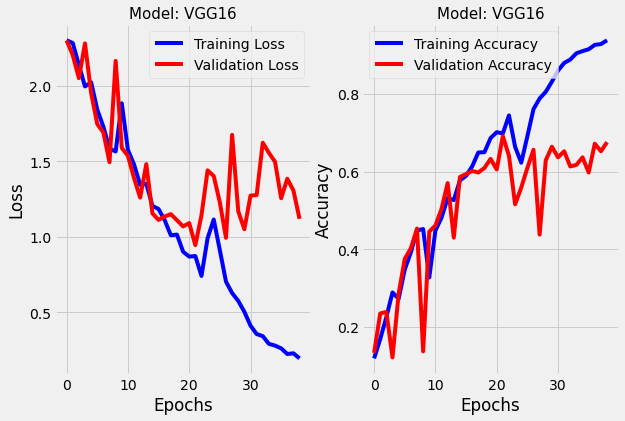

In [25]:
# Plotting learning curve
modelName='VGG16'
modelSaveName='VGG16'
saveFig=True
showfigs=True

PlotHistory(history,modelName,modelSaveName,saveFig, args.save_path, showfigs,args.DPI);

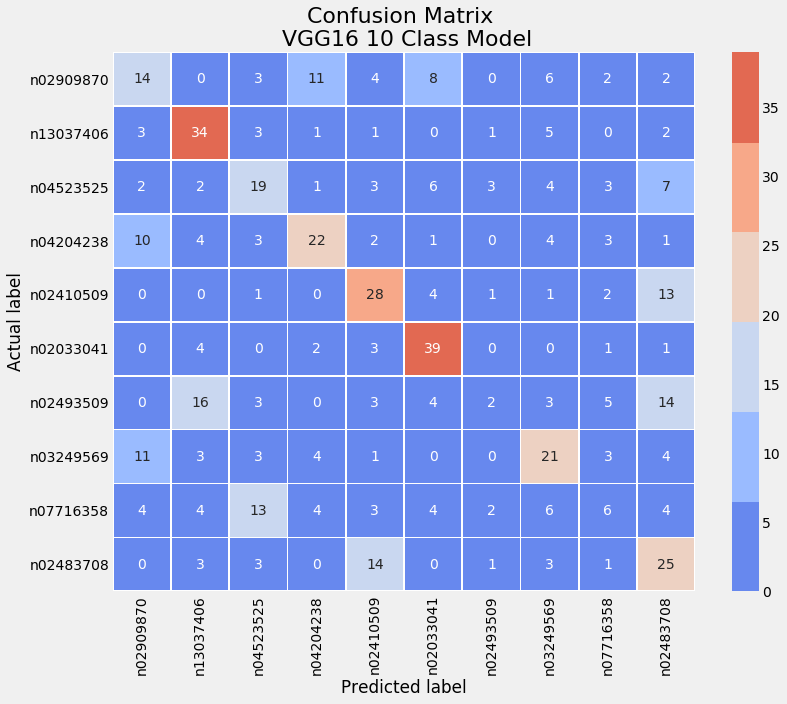

In [33]:
# Plot Confusion Matrix
with strategy.scope():
    predictions=np.argmax(model.predict(test_generator),axis=1)
labels=test_generator.labels
cm = confusion_matrix(labels, predictions)
fig,ax=plt.subplots(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d",ax=ax,cmap=sns.color_palette("coolwarm"),linewidths=0.75)
ax.set_ylabel('Actual label')
ax.set_xlabel('Predicted label')
ax.set_xticklabels(selected_classes, rotation=90)
ax.set_yticklabels(selected_classes, rotation=0)
ax.set_title('Confusion Matrix \n VGG16 10 Class Model',fontsize=22)
fig.tight_layout()
plt.savefig(os.path.join(args.save_path,'Confusion_matrix.png'),bbox_inches='tight',format='png',dpi=args.DPI)
plt.show()
    